Reference: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.applications import VGG16

In [2]:
batchSize = 8 # 64
imgHeight = 256
imgWidth = 256

dataPath = "FastFood"

trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  color_mode = "rgb", 
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)




Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.


In [3]:
valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_dataset(data_list):
    def convt_labels(imgs, label):
        def convert_label(label):
            return np.array([data_list[int(y_i)] for y_i in label.numpy()])
        numeric_label = tf.py_function(convert_label, [label], tf.int32)
        return imgs, numeric_label
    return convt_labels

In [6]:
trainDataset = trainDataset.map(regression_dataset(protein_labels))
testDataset = testDataset.map(regression_dataset(protein_labels))
valDataset = valDataset.map(regression_dataset(protein_labels))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
numClasses = 101

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),


  VGG16(weights=None, include_top=False, input_shape=(imgWidth, imgHeight, 3)),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  # tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(32, 11, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(32, 5, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),


  # tf.keras.layers.Dropout(0.7),

  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(514, activation='sigmoid'),
  # tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.005))
])

In [9]:
learningRate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.Adam(learningRate),
  loss=tf.keras.losses.MSE,
  metrics=['mse', 'mae'])

In [10]:
history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=10,
  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="bestVGGReg.h5", verbose=1, save_best_only=True)]
)

Epoch 1/10
700/700 [==============================] - ETA: 0s - loss: 52.6227 - mse: 52.6142 - mae: 6.3531
Epoch 1: val_loss improved from inf to 51.88383, saving model to bestVGGReg.h5
700/700 [==============================] - 225s 296ms/step - loss: 52.6227 - mse: 52.6142 - mae: 6.3531 - val_loss: 51.8838 - val_mse: 51.8761 - val_mae: 6.1026
Epoch 2/10
700/700 [==============================] - ETA: 0s - loss: 44.6585 - mse: 44.6513 - mae: 5.9263
Epoch 2: val_loss improved from 51.88383 to 48.18063, saving model to bestVGGReg.h5
700/700 [==============================] - 234s 334ms/step - loss: 44.6585 - mse: 44.6513 - mae: 5.9263 - val_loss: 48.1806 - val_mse: 48.1738 - val_mae: 5.9083
Epoch 3/10
700/700 [==============================] - ETA: 0s - loss: 43.9250 - mse: 43.9184 - mae: 5.8448
Epoch 3: val_loss did not improve from 48.18063
700/700 [==============================] - 207s 295ms/step - loss: 43.9250 - mse: 43.9184 - mae: 5.8448 - val_loss: 48.3686 - val_mse: 48.3621 - v

In [11]:
y_pred = model.predict(testDataset)
print(y_pred)
print(model.evaluate(testDataset))

116/116 [==============================] - 11s 85ms/step
[[ 3.2900884]
 [ 9.571965 ]
 [ 9.643492 ]
 [ 8.99423  ]
 [13.424175 ]
 [ 8.287313 ]
 [ 9.855574 ]
 [ 6.9018383]
 [ 7.957979 ]
 [ 5.788105 ]
 [ 6.4347167]
 [ 6.7427235]
 [ 6.20405  ]
 [12.462452 ]
 [ 3.9027324]
 [ 6.8163686]
 [ 9.892718 ]
 [ 7.7732854]
 [ 4.501551 ]
 [ 9.650024 ]
 [ 2.9617174]
 [ 5.4990516]
 [ 9.6549   ]
 [ 9.747293 ]
 [ 4.8074903]
 [ 6.2108035]
 [13.574427 ]
 [ 8.578703 ]
 [14.228819 ]
 [ 5.723737 ]
 [ 2.0456383]
 [ 8.161409 ]
 [10.395533 ]
 [ 5.8666706]
 [10.720884 ]
 [12.065865 ]
 [11.580284 ]
 [ 8.021921 ]
 [ 7.6226373]
 [ 3.735826 ]
 [ 8.881379 ]
 [ 7.70155  ]
 [ 8.856022 ]
 [ 7.050314 ]
 [ 3.6253545]
 [ 6.3504024]
 [ 3.927247 ]
 [ 9.61166  ]
 [10.358633 ]
 [12.978813 ]
 [ 3.9530911]
 [ 5.1709394]
 [11.164873 ]
 [ 3.5623288]
 [10.323065 ]
 [11.85413  ]
 [ 8.222892 ]
 [ 5.189944 ]
 [ 2.7958837]
 [ 6.624025 ]
 [12.085224 ]
 [ 7.5890517]
 [18.021458 ]
 [10.6119585]
 [ 5.210085 ]
 [ 5.0457234]
 [ 9.5774975]
 [ 7.

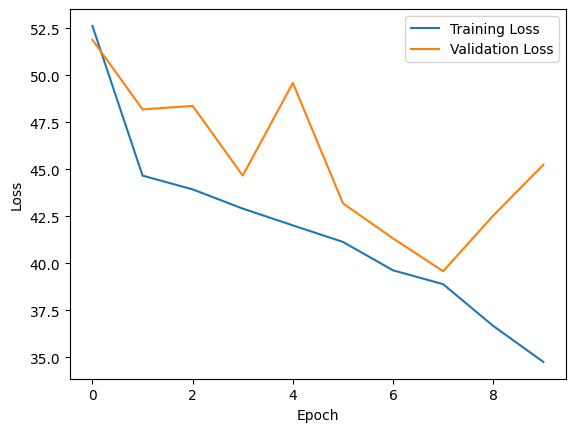

In [12]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save_weights("VGGReg.h5")